### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import sys
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Getting Paths

In [3]:
def get_speaker_roots_in_data_path(datapath = '/content/drive/My Drive/corpus'):
    speaker_list = []
    accent_subfolders = [f.path for f in os.scandir(datapath) if f.is_dir()]
    for accent in accent_subfolders:
        for gender in ['female', 'male']:
            speaker_folders = os.listdir(os.path.join(accent, gender))
            for speaker in speaker_folders:
                if not speaker.startswith('.'):
                    speaker_list.append(os.path.join(accent, gender, speaker))
    return speaker_list

In [4]:
def get_wav_files_in_path(datapath):
    files = os.listdir(datapath)
    files_wav = [i for i in files if 'shortpassage' in i and i.endswith('.wav')]
    return files_wav

### Splitting Audio into 3 Second Chunks

In [5]:
def split_audio():
    audio_chunks = []
    labels = []
    speaker_ids = {}

    speaker_roots = get_speaker_roots_in_data_path()
    for i, speaker_root in enumerate(speaker_roots):
        parts = speaker_root.split('/')
        label = "/".join(parts[7:8])
        speaker_ids[i] = label

        files = get_wav_files_in_path(speaker_root)
        for file in files:
            audio_path = speaker_root + '/' + file

            audio, sr = librosa.load(audio_path)

            samples_per_3_seconds = sr * 3

            for start in range(0, len(audio), int(samples_per_3_seconds)):
                end = start + int(samples_per_3_seconds)

                # If the last chunk is less than 3 seconds long, pad it with zeros
                if end >= len(audio):
                    chunk = np.pad(audio[start:], (0, int(samples_per_3_seconds) - len(audio[start:])))
                else:
                    chunk = audio[start:end]

                audio_chunks.append(chunk)
                labels.append(i)

    return audio_chunks, labels, speaker_ids, sr

In [6]:
def compute_mfccs():
    mfccs = []

    for chunk in audio_chunks:
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr)
        mfccs.append(mfcc)

    return mfccs

In [7]:
audio_chunks, labels, speaker_ids, sr = split_audio()
mfccs = compute_mfccs()

### Splitting Data

In [8]:
speakers = {}
for i in range(len(labels)): # creating a dictionary containing the mfccs of each speaker
    label = labels[i]
    mfcc = mfccs[i]
    if label in speakers:
        speakers[label].append(mfcc)
    else:
        speakers[label] = [mfcc]

In [9]:
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

for i in set(labels): # for each speaker, psplit data. prevents class imbalance
    speaker_mfccs = speakers[i] # get all mfccs of the speaker 'i'
    speaker_label = np.repeat(i, len(speaker_mfccs))
    speaker_label = to_categorical(speaker_label, num_classes=len(set(labels)))

    X_temp, X_test_temp, y_temp, y_test_temp = train_test_split(speaker_mfccs, speaker_label, test_size=0.2, random_state=1) # 20% to test
    X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=1) # 20% of the reminaing 80% to val

    for data in X_train_temp:
        X_train.append(data)

    for data in X_val_temp:
        X_val.append(data)

    for data in X_test_temp:
        X_test.append(data)

    for data in y_train_temp:
        y_train.append(data)

    for data in y_val_temp:
        y_val.append(data)

    for data in y_test_temp:
        y_test.append(data)

In [10]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

### Reshaping Sets for Training

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

### Defining F1 Score, Precision and Recall Metrics

In [12]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Building the Model

In [13]:
model = models.Sequential()

# CNN Layers
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

# Flatten
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(len(set(labels)), activation='softmax'))

In [14]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
277/277 [==============================] - 14s 25ms/step - loss: 5.6875 - accuracy: 0.0045 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.6476 - val_accuracy: 0.0085 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
277/277 [==============================] - 4s 16ms/step - loss: 5.6478 - accuracy: 0.0076 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.6453 - val_accuracy: 0.0089 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
277/277 [==============================] - 4s 15ms/step - loss: 5.6450 - accuracy: 0.0088 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.6426 - val_accuracy: 0.0093 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
277/277 [==============================] - 5s 17ms/step - loss: 5.6403 - accuracy: 0.0084 - f1_m: 0.0000e+00 - 

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 130, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 130, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 65, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 65, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 65, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 65, 64)        36928     
                                                        

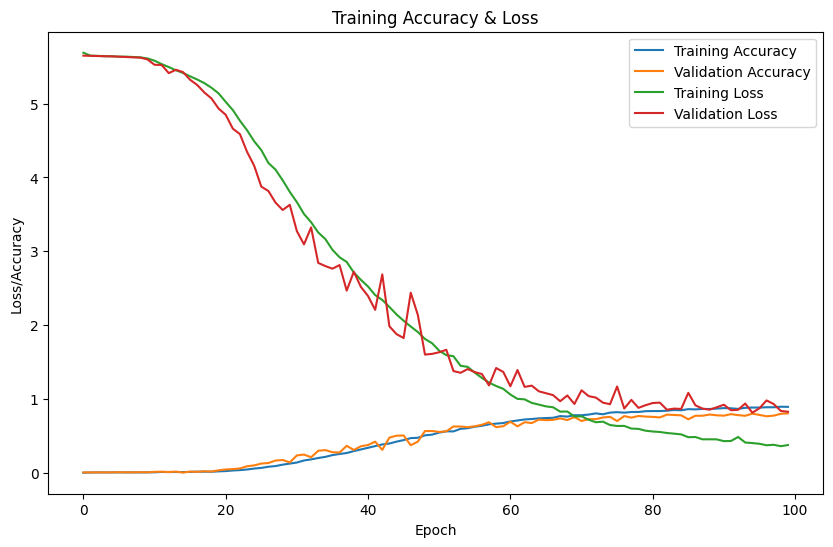

In [17]:
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-')

# Plot loss
plt.plot(history.history['loss'], label='Training Loss', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-')

plt.title('Training Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()

#plt.savefig('Adam.jpeg')

plt.show()

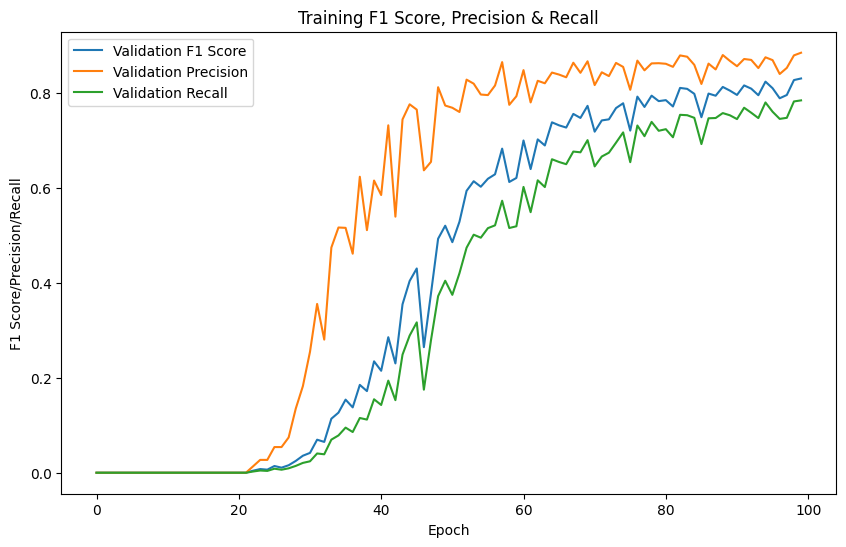

In [18]:
plt.figure(figsize=(10, 6))

# Plot f1score
plt.plot(history.history['val_f1_m'], label='Validation F1 Score', linestyle='-')

# Plot precision
plt.plot(history.history['val_precision_m'], label='Validation Precision', linestyle='-')

# Plot recall
plt.plot(history.history['val_recall_m'], label='Validation Recall', linestyle='-')

plt.title('Training F1 Score, Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('F1 Score/Precision/Recall')
plt.legend()

plt.savefig('f1training.jpeg')

plt.show()

### Evaluation

In [19]:
model.evaluate(X_test, y_test)

92/92 [==============================] - 1s 14ms/step - loss: 0.6129 - accuracy: 0.8415 - f1_m: 0.8575 - precision_m: 0.9012 - recall_m: 0.8197


[0.6129343509674072,
 0.8414965867996216,
 0.8574682474136353,
 0.9011955857276917,
 0.8196816444396973]